# 1| Intro

Anyone interested in Reinforcement Learning probably came across **OpenAI's** [Gym](https://gym.openai.com/docs/) or [Universe](https://blog.openai.com/universe/). Using **Universe** it is possible to train AI to play video games and perform several real-world tasks.
Due to the architecture that Universe is using to run RL algorithms like A3C for games like Mario, it can be quite challenging to achieve proper actor performance using your own machine.

As stated in his [blog](https://blog.aqnichol.com/2017/06/11/why-im-remaking-openai-universe/) this was one of the reasons why [Alex Nichol](https://github.com/unixpickle) created [µuniverse](https://github.com/unixpickle/muniverse). µuniverse is providing RL environments for HTML5 based games running Chrome in headless mode instead of using VNC and Flash. If you're interested in µuniverse I highly recommend to try it out and read the blog.

# 2| Reading the Logs

After I was performing a couple of iterations training *A3C agents* on different games provided by µuniverse, I wanted to know how the performance of my agents is increasing (hopefully) across episodes. Although the µuniverse-agents are printing some performance metrics to stdout, it seems that there is no tool integrated to visualize those (maybe I didn't find the proper command line flag). 

A simple solution is to redirect the stdout and stderr to a text file and analyze the logs:
**`muniverse-agent a3c -env DoodleJump-v0 -out doodlejump >> log_doodle.txt 2>&1`**

Therefore I build a small set of helpers to visualize different metrics that are written to the logs.

In [171]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
%matplotlib inline

# Regex to clean up the log data
p_descr = re.compile('([a-z_]+\:[ ])')
p_var = re.compile('([a-z_]+=)')

The following method cleans up the µuniverse-agent log file by removing unnecesary prefixes, descriptions and other log statements and maps the relevant entries to lists which will be loaded into Pandas DataFrames afterwards. A sample log file can be found in this repository.

In [162]:
def clean_log_file(file_name):
    '''
    Cleans a µuniverse-agent log file and returns a tuple containing 
    lists for episode, update and regularization information.
    '''
    with open(file_name) as f:
        content = f.readlines()
    content = [x.strip('\n') for x in content]
    episodes =  [ list(map(str.strip, p_var.sub('#', p_descr.sub('', x)).split('#'))) for x in content if 'episode' in x ]
    updates = [ list(map(str.strip, p_var.sub('#', p_descr.sub('', x)).split('#'))) for x in content if 'update' in x ]
    regularizations = [ list(map(str.strip, p_var.sub('#', p_descr.sub('', x)).split('#'))) for x in content if 'regularize' in x ]
    return (episodes, updates, regularizations)
    

In [163]:
episodes, updates, regs = clean_log_file('./log_doodle.txt')

In [164]:
print("Episode information:", episodes[0:2])
print("Update information:", updates[0:2])
print("Regularization information:", regs[0:2])

Episode information: [['2017/11/04 05:54:31', '1', '0.030000'], ['2017/11/04 05:54:31', '3', '0.030000']]
Update information: [['2017/11/04 05:54:52', '2', '0.139347'], ['2017/11/04 05:55:16', '7', '0.121225']]
Regularization information: [['2017/11/04 05:54:32', '2', '0.020794291'], ['2017/11/04 05:54:34', '6', '0.02079431']]


## 3| Preparing Pandas DataFrame Objects

The following cell shows the code to prepare the DataFrame objects. This includes the proper data type conversion as well as assigning the correct column labels.

In [165]:
# Load sample list into data frame and assign column values
episodes_df = pd.DataFrame(episodes, columns = ['DateTime', 'Worker', 'Reward'])
updates_df = pd.DataFrame(updates, columns = ['DateTime', 'Worker', 'CriticMSE'])
regs_df = pd.DataFrame(regs, columns = ['DateTime', 'Worker', 'Term'])

# Convert strings to proper numeric values
episodes_df.Reward = episodes_df.Reward.astype(float)
updates_df.CriticMSE = updates_df.CriticMSE.astype(float)
regs_df.Term = regs_df.Term.astype(float)

# Convert strings to datetime
episodes_df.DateTime = pd.to_datetime(episodes_df.DateTime, format="%Y/%m/%d %H:%M:%S")
updates_df.DateTime = pd.to_datetime(updates_df.DateTime, format="%Y/%m/%d %H:%M:%S")
regs_df.DateTime = pd.to_datetime(regs_df.DateTime, format="%Y/%m/%d %H:%M:%S")

In [166]:
episodes_df.head()

,DateTime,Worker,Reward
0,2017-11-04 05:54:31,1,0.030
1,2017-11-04 05:54:31,3,0.030
2,2017-11-04 05:54:32,0,0.280
3,2017-11-04 05:54:34,5,0.824
4,2017-11-04 05:54:35,7,0.636


In [167]:
updates_df.head()

,DateTime,Worker,CriticMSE
0,2017-11-04 05:54:52,2,0.139347
1,2017-11-04 05:55:16,7,0.121225
2,2017-11-04 05:55:44,3,0.157116
3,2017-11-04 05:56:09,2,0.106735
4,2017-11-04 05:56:39,3,0.162724


In [168]:
regs_df.head()

,DateTime,Worker,Term
0,2017-11-04 05:54:32,2,0.020794
1,2017-11-04 05:54:34,6,0.020794
2,2017-11-04 05:54:37,0,0.020794
3,2017-11-04 05:54:40,0,0.020794
4,2017-11-04 05:54:42,5,0.020794


## 4| Smoothed Reward over Time
The data frames can now be plotted to get an understanding of the performance of different metrics over time. In the following example I've plotted the smoothed reward over time and across episodes.

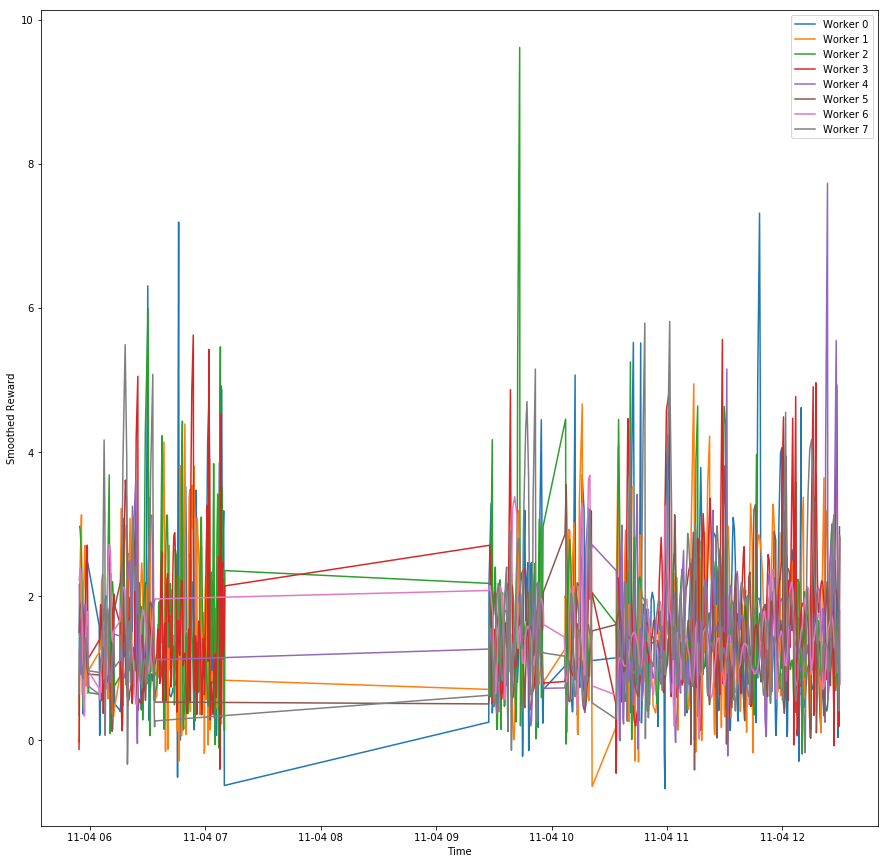

In [169]:
episodes_index_df = episodes_df.set_index('DateTime')
grouped = episodes_index_df.groupby(['Worker'])
plt.subplots(figsize=(15,15))
for key, group in grouped:
    y = group.Reward
    x = range(0,len(y)) 
    # s chosen based on splrep documentation
    # https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.interpolate.splrep.html
    t, c, k = interpolate.splrep(x, y, s=850, k=3)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    plt.plot(group.index, spline(x), label="Worker "+str(key))
    
plt.legend(loc='upper right')
plt.xlabel("Time")
plt.ylabel("Smoothed Reward")
plt.show()

# Plot the complete reward data set

#_, ax = plt.subplots(figsize=(20, 20))
#sb.tsplot(data=episodes_df, time="DateTime", unit='Worker', condition='Worker', value="Reward", ax=ax)


## 5| Smoothed Reward over Episodes per Agent

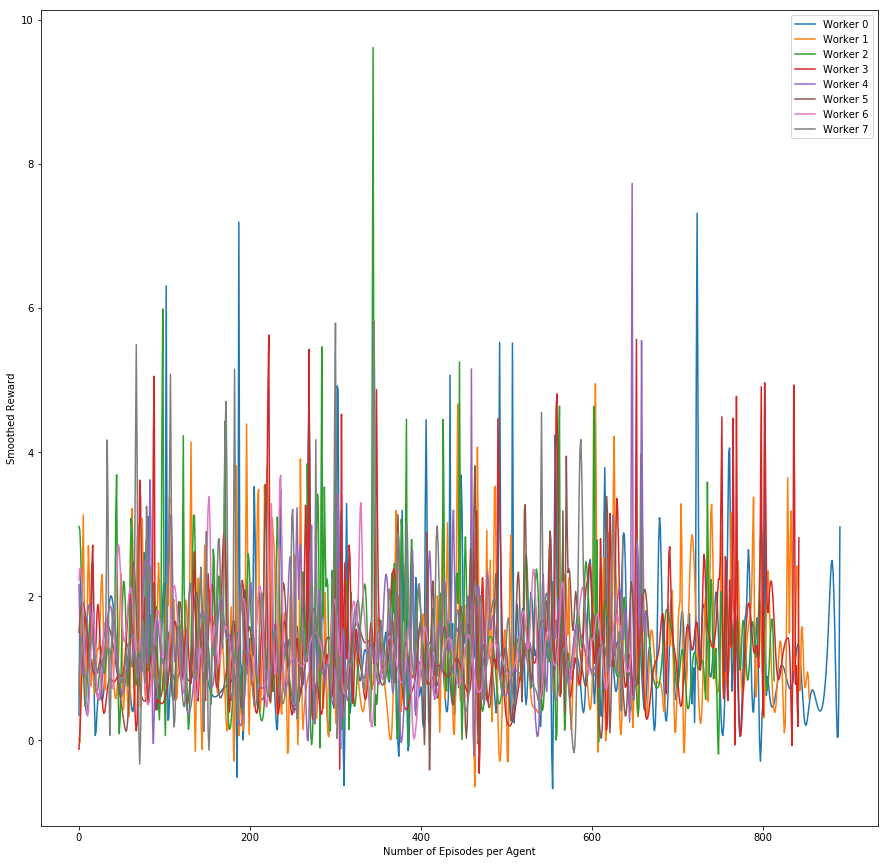

In [170]:
episodes_index_df = episodes_df.set_index('DateTime')
grouped = episodes_index_df.groupby(['Worker'])
plt.subplots(figsize=(15,15))
for key, group in grouped:
    y = group.Reward
    x = range(0,len(y)) 
    # s chosen based on splrep documentation
    # https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.interpolate.splrep.html
    t, c, k = interpolate.splrep(x, y, s=850, k=3)
    spline = interpolate.BSpline(t, c, k, extrapolate=False)
    plt.plot(x, spline(x), label="Worker "+str(key))

    
plt.legend(loc='upper right')
plt.xlabel("Number of Episodes per Agent")
plt.ylabel("Smoothed Reward")
plt.show()

## 6| Conclusion 
Using some basic plots in Python can help you to get an understanding of your agent's performance. Although not that complex and helpful as the visualization of logs in Tensorboard but powerful enough to get a good understanding.

Thanks to Open AI, Alex Nichol and all others engaged in the open source community giving everyone the power to use such algorithms.

If you have comments, ideas or remarks feel free to reach out to me on **[Twitter](https://twitter.com/8B_EC)** or **[Medium](medium.com/@8B_EC) @8B_EC**